In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
%matplotlib inline
from glob import glob #retriving an array of files in directories
import cv2
import random
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score,mean_absolute_error,median_absolute_error,mean_squared_error,mean_squared_log_error
import seaborn as sns 
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.layers import SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing import image
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator   ##Data augmentation and preprocessing
from sklearn.metrics import classification_report
import time
import re
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import gc
import pathlib
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix


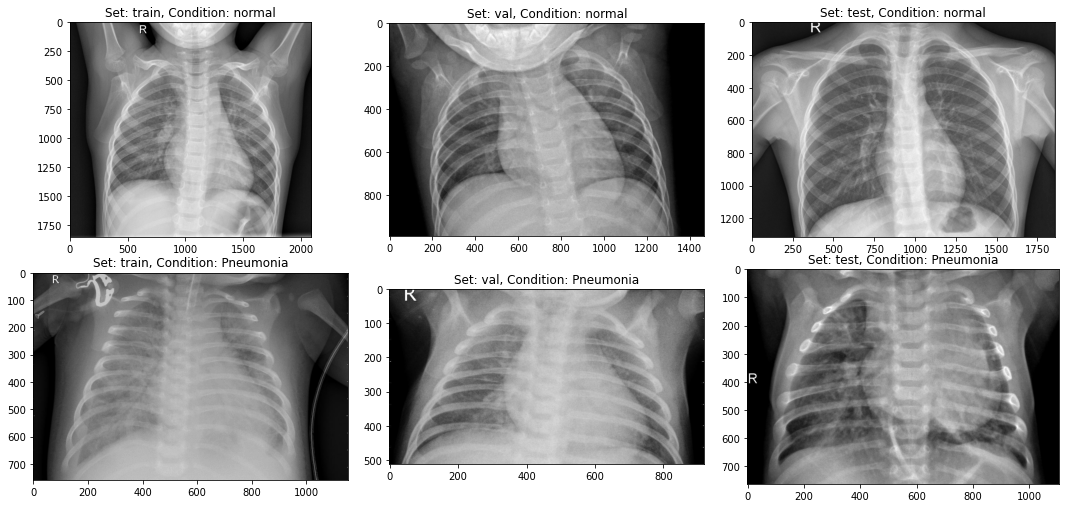

In [2]:
input_path = 'C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

#Generating the list of sample images
for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/normal/'+os.listdir(set_path+'/normal')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/pneumonia/'+os.listdir(set_path+'/pneumonia')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [3]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/normal'))
    n_infect = len(os.listdir(input_path + _set + '/pneumonia'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [4]:
#Image Preprocessing

path_train = "C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/train"
path_val = "C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/val"
path_test = "C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/test"

classes = ["NORMAL", "PNEUMONIA"]
train_data = glob(path_train+"/NORMAL/*.jpeg")
train_data += glob(path_train+"/PNEUMONIA/*.jpeg")
data_gen = ImageDataGenerator() #Augmentation happens here

In [5]:
#DATA AUGMENTATION -

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, shear_range = 0.2, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
   
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    

    test_data = []
    test_labels = []

    for cond in ['/normal/', '/pneumonia/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/normal/':
                label = 0
            elif cond=='/pneumonia/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
####################### CASE 3 ############################

In [41]:
#We start with defining some of the constants that we will be using during the model creation phase.
img_dims = 150
batch_size = 50



In [42]:
#Creating the architecture of the model.
from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Nadam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import cv2, numpy as np

inputs = Input(shape=(img_dims, img_dims, 3))
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

#ADDING OPTIMIZER ADAM
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [17]:
from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Nadam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'sigmoid')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Nadam(lr=0.0004) #learning_rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [43]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_33 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_34 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_23 (Batc (None, 75, 75, 32)      

In [10]:

# trained the model for 45 epochs with a batch size of 50.
hist = model.fit_generator(
           train_gen, steps_per_epoch=10 // batch_size, 
           epochs=45, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/45
104/104 [==============================] - 255s 2s/step - loss: 0.4984 - accuracy: 0.7793 - val_loss: 0.7070 - val_accuracy: 0.6283
Epoch 2/45
104/104 [==============================] - 279s 3s/step - loss: 0.3056 - accuracy: 0.8730 - val_loss: 0.6607 - val_accuracy: 0.6267
Epoch 3/45
104/104 [==============================] - 256s 2s/step - loss: 0.2663 - accuracy: 0.8953 - val_loss: 0.7169 - val_accuracy: 0.6300
Epoch 4/45
104/104 [==============================] - 245s 2s/step - loss: 0.2634 - accuracy: 0.8943 - val_loss: 0.6587 - val_accuracy: 0.6283
Epoch 5/45
104/104 [==============================] - 196s 2s/step - loss: 0.2334 - accuracy: 0.9102 - val_loss: 1.1000 - val_accuracy: 0.6250
Epoch 6/45
104/104 [==============================] - 192s 2s/step - loss: 0.2215 - accuracy: 0.9199 - val_loss: 1.4920 - val_accuracy: 0.6250
Epoch 7/45
104/104 [==============================] - 196s 2s/step

Epoch 39/45
104/104 [==============================] - 187s 2s/step - loss: 0.1341 - accuracy: 0.9516 - val_loss: 0.2422 - val_accuracy: 0.9200
Epoch 40/45
104/104 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9506
Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.2914016210563428e-12.
104/104 [==============================] - 189s 2s/step - loss: 0.1324 - accuracy: 0.9506 - val_loss: 0.2391 - val_accuracy: 0.9217
Epoch 41/45
104/104 [==============================] - 199s 2s/step - loss: 0.1393 - accuracy: 0.9499 - val_loss: 0.2367 - val_accuracy: 0.9217
Epoch 42/45
104/104 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9524
Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.874204993273289e-13.
104/104 [==============================] - 257s 2s/step - loss: 0.1300 - accuracy: 0.9524 - val_loss: 0.2429 - val_accuracy: 0.9217
Epoch 43/45
104/104 [==============================] - 277s 3s/step - loss: 0.1324 - accuracy

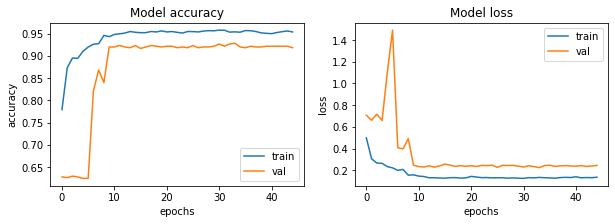

In [11]:
#visualize the loss and accuracy plots.

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
# ACCURACY AND LOSS FOR VALIDATION
model.evaluate(test_gen)   

13/13 [==============================] - 7s 553ms/step - loss: 0.2383 - accuracy: 0.9215


[0.23830866813659668, 0.9214743375778198]

In [13]:
# ACCURACY AND LOSS FOR TRAIN

model.evaluate(train_gen)

105/105 [==============================] - 91s 868ms/step - loss: 0.1148 - accuracy: 0.9590


[0.1147962436079979, 0.9589723944664001]

In [14]:
import itertools

def Confusion_matrix(cm, classes,normalize=False,title='CONFUSION MATRIX',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


  PERFORMANCE METRICS
Accuracy: 91.98717948717949%
Precision: 90.66985645933015%
Recall: 97.17948717948718%
F1-score: 93.8118811881188


Train acc: 95.37
ROC AUC: 0.902564


              precision    recall  f1-score   support

      normal       0.95      0.83      0.89       234
    pnemonia       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



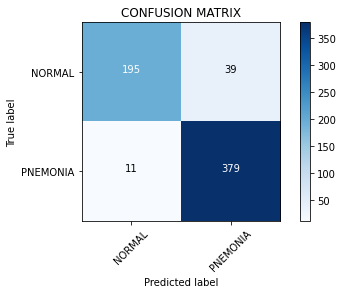

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

preds = model.predict(test_data)


acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('\n  PERFORMANCE METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print()
print()
Confusion_matrix(cm, classes=['NORMAL', 'PNEMONIA'])
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

auc = roc_auc_score(test_labels, np.round(preds))
print('ROC AUC: %f' %auc)


print()
print()
print(classification_report(test_labels, np.round(preds), target_names=['normal','pnemonia']))

In [ ]:
################ CASE 4 #########################

In [18]:

img_dims = 60
batch_size = 50


train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adamax
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='selu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'sigmoid')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Adamax(lr=0.006) #learning_rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]


In [34]:
history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=50,
                              validation_data=(test_gen),validation_steps=test_gen.samples,callbacks=callbacks_list)

Epoch 1/50
104/104 [==============================] - 125s 1s/step - loss: 0.2838 - accuracy: 0.8757 - val_loss: 0.7122 - val_accuracy: 0.3700
Epoch 2/50
104/104 [==============================] - 126s 1s/step - loss: 0.2746 - accuracy: 0.8868 - val_loss: 0.6647 - val_accuracy: 0.6217
Epoch 3/50
104/104 [==============================] - 129s 1s/step - loss: 0.2652 - accuracy: 0.8935 - val_loss: 1.3776 - val_accuracy: 0.6250
Epoch 4/50
104/104 [==============================] - 121s 1s/step - loss: 0.2423 - accuracy: 0.8959 - val_loss: 2.2419 - val_accuracy: 0.6233
Epoch 5/50
104/104 [==============================] - 119s 1s/step - loss: 0.2381 - accuracy: 0.9024 - val_loss: 2.6452 - val_accuracy: 0.6250
Epoch 6/50
104/104 [==============================] - 119s 1s/step - loss: 0.2303 - accuracy: 0.9069 - val_loss: 2.6785 - val_accuracy: 0.6217
Epoch 7/50
104/104 [==============================] - 118s 1s/step - loss: 0.2291 - accuracy: 0.9094 - val_loss: 3.0294 - val_accuracy: 0.6267

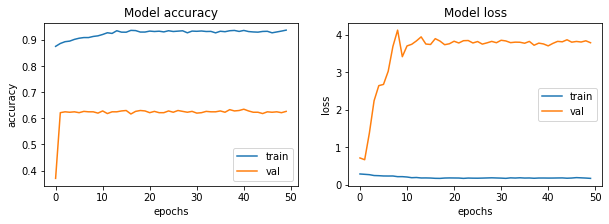

In [35]:
#visualize the loss and accuracy plots.

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
# ACCURACY AND LOSS FOR VALIDATION
model.evaluate(test_gen)   

13/13 [==============================] - 9s 722ms/step - loss: 3.8098 - accuracy: 0.6250


[3.809821844100952, 0.625]

In [37]:
# ACCURACY AND LOSS FOR TRAIN
model.evaluate(train_gen)

105/105 [==============================] - 94s 891ms/step - loss: 0.1586 - accuracy: 0.9373


[0.15855060517787933, 0.9373083114624023]

In [38]:
import itertools

def Confusion_matrix(cm, classes,normalize=False,title='CONFUSION MATRIX',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


  PERFORMANCE METRICS
Accuracy: 62.5%
Precision: 62.5%
Recall: 100.0%
F1-score: 76.92307692307692


Train acc: 93.79


              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       234
    pnemonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\Acer\anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

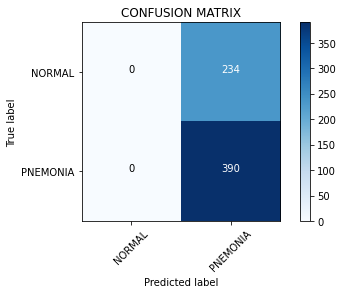

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

preds = model.predict(test_data)


acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('\n  PERFORMANCE METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print()
print()
Confusion_matrix(cm, classes=['NORMAL', 'PNEMONIA'])
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


print()
print()
print(classification_report(test_labels, np.round(preds), target_names=['normal','pnemonia']))